Setup

In [1]:
%matplotlib inline

import dataLoader
import matplotlib.pyplot as plt
import torch
import CNN
import itertools

# hyper param search
hyperp = {
    "n_epochs": 1000,
    "batchSize": 200,
    "numOfTrials": 3,
    "training_count": 2,
    "validation_count": 1,
    "imgH": 28,
    "imgW": 28,
    "kernels": [16, 32],
    "kernelSize": 5
}

# defining global variables
image_path = "./Fish_toy/images"

# hyper-parameter search
hyperp_grid_params = {
    "dummy": [0], #  keep this when you only need one model
}

Cuda support

In [2]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

Number of images =  117
0 Abudefduf vaigiensis  has  4  images
1 Pardachirus pavoninus  has  5  images
2 Wetmorella albofasciata  has  5  images
3 Zebrasoma scopas  has  5  images
4 Acanthurus achilles  has  5  images
5 Anampses caeruleopunctatus  has  5  images
6 Wetmorella nigropinnata  has  5  images
7 Variola albimarginata  has  4  images
8 Upeneus moluccensis  has  5  images
9 Xiphocheilus typus  has  4  images
10 Acanthurus coeruleus  has  5  images
11 Acanthopagrus pacificus  has  3  images
12 Ablabys taenianotus  has  5  images
13 Acanthurus chirurgus  has  5  images
14 Amphiprion clarkii  has  5  images
15 Xenisthmus polyzonatus  has  5  images
16 Acanthemblemaria spinosa  has  4  images
17 Acanthemblemaria aspera  has  5  images
18 Acanthurus bahianus  has  4  images
19 Anampses geographicus  has  5  images
20 Amphiprion polymnus  has  5  images
21 abudefduf septemfasciatus  has  4  images
22 Lepidozygus tapeinosoma  has  5  images
23 Xanthichthys auromarginatus  has  5  imag

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:45:22 Time:  1:45:22
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:27:59 Time:  1:27:59
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:39:13 Time:  1:39:13
/home/elhamod/Insync/mndhamod@gmail.com/Google Drive/Colab Notebooks/BGNN/confusion_matrix_plotter.py:60: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


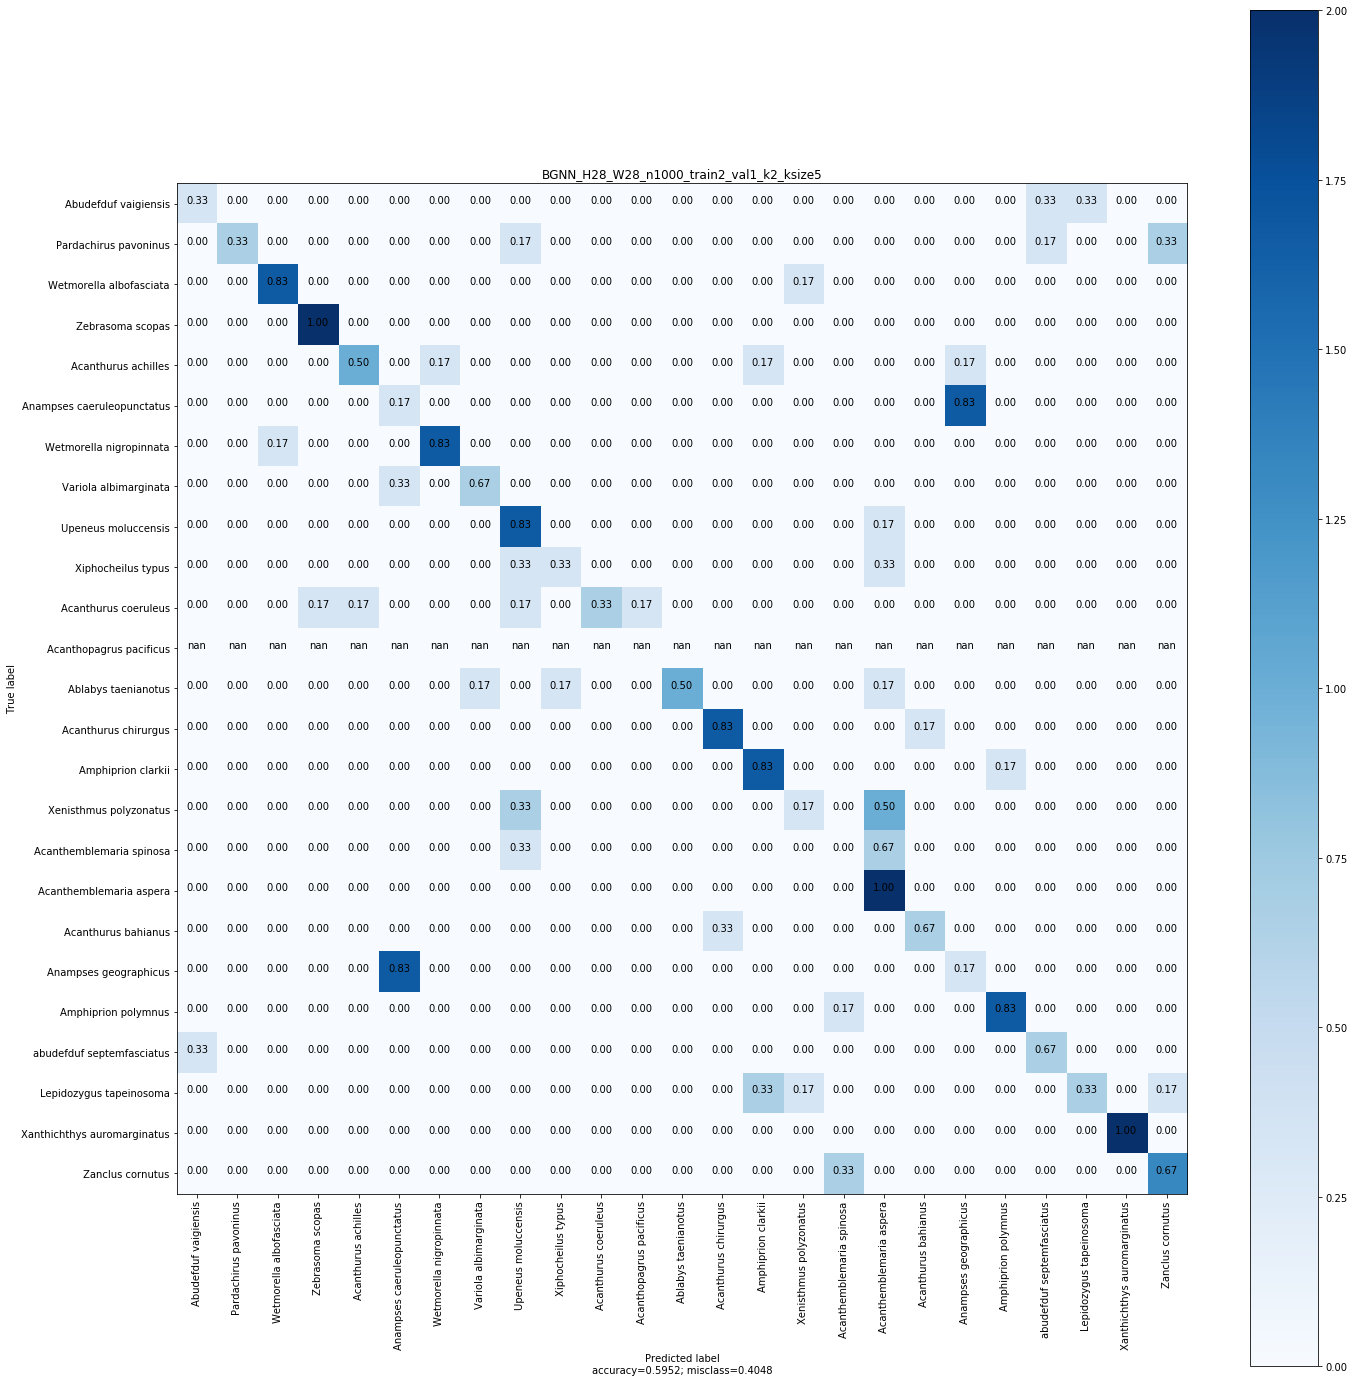

In [3]:
import torchvision
from sklearn.metrics import confusion_matrix
from confusion_matrix_plotter import plot_confusion_matrix2
from helper import getModelName
import numpy as np

# get possible experiments
keys, values = zip(*hyperp_grid_params.items())
product = itertools.product(*values)
product_len = len(list(product))

# Just used to print information about data set
dummy = 10
dataLoader.FishDataset(image_path, dummy, dummy, True)
confusionMatrices = []
datasets = []

for v in itertools.product(*values):
    # create experiment params
    experiment_params = dict(zip(keys, v))
    experiment_params = {**hyperp, **experiment_params}
    numOfTrials = experiment_params["numOfTrials"]
    imgH = experiment_params["imgH"]
    imgW = experiment_params["imgW"]
    n_epochs = experiment_params["n_epochs"]
    batchSize = experiment_params["batchSize"]
    training_count = experiment_params["training_count"]
    validation_count = experiment_params["validation_count"]
    kernels = experiment_params["kernels"]
    kernelSize = experiment_params["kernelSize"]
    
    # load images
    dataset = dataLoader.FishDataset(image_path, imgH, imgW)
    datasets.append(dataset)
    numberOfSpecies = len(dataset.getSpeciesList())
    
    confusionMatricesPerExperiment = []
    
    for i in range(numOfTrials):

        # Initialize the prediction and label lists(tensors)
        predlist=torch.zeros(0)
        lbllist=torch.zeros(0)

        # get Loaders
        train_loader, validation_loader, test_loader = dataLoader.getLoadersFromDataset(dataset, training_count, validation_count, batchSize)

        model = CNN.CNN(numberOfSpecies, imgH, imgW, kernels, kernelSize)
        loss_list, accuracy_list = CNN.trainModel(train_loader, validation_loader, n_epochs, model, int(n_epochs/10))


        with torch.no_grad():
            for batch in test_loader:
                inputs = batch["image"]
                classes = batch["class"]
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                predlist=torch.cat([predlist,preds.float().view(-1)])
                lbllist=torch.cat([lbllist,classes.float().view(-1)])

        # Confusion matrix
        confusionMatricesPerExperiment.append(confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy(), labels = range(numberOfSpecies)))
    
    conf_mat = np.mean(confusionMatricesPerExperiment, axis=0) 
    plot_confusion_matrix2(conf_mat,
                              dataset.getSpeciesList(),
                              title=getModelName(experiment_params))